# SIRD Model 3

Basic SIRD model for Indonesia Covid 
(data until 20200328)

![SIRD](../images/Scheme-of-Susceptible-Infectious-Recovered-Death-SIRD-Model-Boxes-represent.png)

In [1]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [2]:
import pandas as pd
import scipy.integrate as spi
import numpy as np
import seaborn as sns

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
import datetime as dt
import pyswarms as ps
from pyswarms.utils.functions import single_obj as fx

In [3]:
PATH_DATA = '../data/raw/'

In [4]:
## Assumption
NUMB_OF_POPS=200000000

In [5]:
aa=np.array([[2],[3]])
fx.sphere(aa)

array([4., 9.])

## Get The Data

Getting the data and do the summary

In [6]:
df_daily=pd.read_csv(PATH_DATA+'20200328_DailyCase_ID.csv')
df_daily=df_daily.fillna(0)

df_daily['Rec']=df_daily['Sembuh (baru)'].cumsum()
df_daily['Dea']=df_daily['Meninggal (baru)'].cumsum()
df_daily['Inf']=df_daily['Kasus (Kumulatif)']-df_daily['Rec']-df_daily['Dea']
df_daily['Sus']=NUMB_OF_POPS-df_daily['Inf']-df_daily['Rec']-df_daily['Dea']

col_use=['Sus','Inf','Rec','Dea']
df_daily_sird=df_daily[col_use]/NUMB_OF_POPS

for cc in col_use:
    df_daily_sird[cc+'_before']=df_daily_sird[cc].shift(1)
    df_daily_sird[cc+'_dt']=df_daily_sird[cc]-df_daily_sird[cc+'_before']

col_use_t=['Sus_dt','Inf_dt','Rec_dt','Dea_dt']
df_daily_sird2=df_daily_sird[col_use+col_use_t].dropna()

In [7]:
# df_daily_sird[['Inf','Rec','Dea']].plot(figsize=(10,8))

## Tuning Parameter SIRD Model

In [8]:
def sird_model_diff(VALUE_ON_T,t,param_bk,param_rk,param_mk):  
    '''The main set of equations'''
    Y=np.zeros((4))
    dS,dI,dR,dD = VALUE_ON_T  
    Y[0] = - param_bk * dS * dI
    Y[1] = (param_bk * dS * dI) - (param_rk * dI) - (param_mk * dI)
    Y[2] = param_rk * dI
    Y[3] = param_mk * dI
    
    return Y   # For odeint

In [9]:
def targ_func(x,df=df_daily_sird2):
    param_b,param_r,param_m=x
    N=200000000000
    T_start = 0.0
    T_inc=1.0
    T_end=26
    I0=2/NUMB_OF_POPS
    S0=1-I0
    INPUT = (S0, I0, 0.0, 0.0)
    
    col_use_pred=[x+'_pred' for x in col_use]
    T_range = np.arange(T_start, T_end+T_inc, T_inc)
    RES = spi.odeint(sird_model_diff,INPUT,T_range, args=(param_b,param_r,param_m))
    df_sird_pred=pd.DataFrame(RES,columns=col_use_pred)
    df[col_use_pred]=df_sird_pred[1:len(df_daily_sird2)+1]
    
    
    eS=((df['Sus']-df['Sus_pred'])**2).sum()*N*0.4
    eI=((df['Inf']-df['Inf_pred'])**2).sum()*N*0.25
    eR=((df['Rec']-df['Rec_pred'])**2).sum()*N*0.15
    eD=((df['Dea']-df['Dea_pred'])**2).sum()*N*0.1
    
    return (eS+eI+eR+eD)

def opt_func(x):
    all_res=[]
    for i in x:
        res=targ_func(i)
        all_res.append(res)
    return np.array(all_res)

In [10]:
# targ_func([[0.3],[0.05],[0.05]])

In [11]:
opt1 = {'c1': 0.15, 'c2': 0.95, 'w':0.25}
pos_res=[]
best_pos=[]
min_func=100
for i in range(3):
    optimizer1 = ps.single.GlobalBestPSO(n_particles=200, dimensions=3, options=opt1,
                                         bounds=([0.1,0.005,0.005],[0.5,0.1,0.1]))
    # Perform optimization
    cost, pos = optimizer1.optimize(opt_func, iters=20)
    pos_res.append(pos)
    if cost<min_func:
        min_func=cost
        best_pos=pos
        
max_bound2=np.array(pos_res).max(axis=0)
max_bound2=max_bound2+(max_bound2*0.08)
min_bound2=np.array(pos_res).min(axis=0)
min_bound2=min_bound2-(min_bound2*0.08)
optimizer2 = ps.single.GlobalBestPSO(n_particles=150, dimensions=3, options=opt1,
                                         bounds=(min_bound2,max_bound2))
cost, pos = optimizer2.optimize(opt_func, iters=40)
pos_res.append(pos)
if cost<min_func:
    min_func=cost
    best_pos=pos

2020-03-28 18:08:54,305 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.15, 'c2': 0.95, 'w': 0.25}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=0.862
2020-03-28 18:09:06,133 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.8615774850408408, best pos: [0.29124746 0.01848258 0.03083619]
2020-03-28 18:09:06,141 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.15, 'c2': 0.95, 'w': 0.25}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=0.862
2020-03-28 18:09:17,856 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.8615668208633501, best pos: [0.2905441  0.01806553 0.03046589]
2020-03-28 18:09:17,864 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.15, 'c2': 0.95, 'w': 0.25}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=0.862
2020-03-28 18:09:29,634 - pyswarms.single.global_best - INFO - Optimization finished | best 

In [90]:
# targ_func([0.2938,0.01762,0.02953])
# [0.29493264 0.01717436 0.03094745] --> 20200327 ()
# [0.29086823 0.01775272 0.03114078] --> 20200328 (0.861544363)

0.5659512231993404

In [20]:
# Opt_Targ = BayesianOptimization(targ_func, {'param_b': (0.3, 0.38),'param_r': (0.04, 0.053),'param_m': (0.04, 0.053)})

In [22]:
# Opt_Targ.maximize(init_points=40, n_iter=25)

In [23]:
param_bc,param_rc,param_mc=0.2938,0.01762,0.02953
# param_bc,param_rc,param_mc=0.3,0.02,0.03

# param_bc,param_rc,param_mc=0.3292,0.04154,0.04643

In [24]:
T_start = 0.0
T_inc=1.0
T_end=30*6
I0=2/NUMB_OF_POPS
S0=1-I0
INPUT = (S0, I0, 0.0, 0.0)

col_use_pred=[x+'_pred' for x in col_use]
T_range = np.arange(T_start, T_end+T_inc, T_inc)
RES = spi.odeint(sird_model_diff,INPUT,T_range, args=(param_bc,param_rc,param_mc))

In [25]:
df_sird_pred=pd.DataFrame(RES,columns=['Sus','Inf','Rec','Dea'])

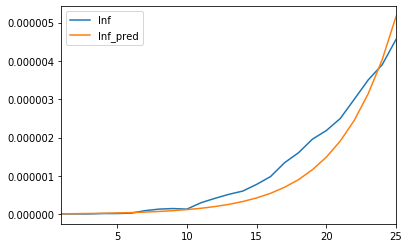

In [87]:
check_col='Inf'
col_use_pred=[x+'_pred' for x in col_use]
df_daily_sird2[col_use_pred]=df_sird_pred[1:len(df_daily_sird2)+1]
df_daily_sird2[[check_col,check_col+'_pred']].plot()

In [123]:
# df_sird_pred['Dea_pred'].max()

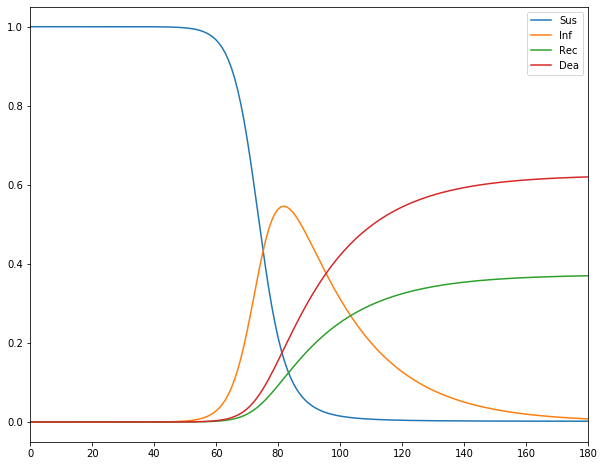

In [27]:
# df_sird_pred[['Inf','Rec','Dea']].plot()
df_sird_pred.plot(figsize=(10,8))

In [67]:
date_1 = dt.datetime.strptime("2020-03-02", "%Y-%m-%d")

## Interactive

In [77]:
curr_bc = 0.2938
curr_rc = 0.01762
curr_mc = 0.02953

In [127]:
@interact
def show_graph(rco=(0,0.5,0.008),
               mco=(0,0.5,0.0075),
               bco=(0,0.5,0.005),
               all_pred_metric=False,
               metr=col_use,range_time=(3,365,2)):
    
    T_start = 0.0
    T_inc=1.0
    T_end=range_time
    I0=2/NUMB_OF_POPS
    S0=1-I0
    INPUT = (S0, I0, 0.0, 0.0)

    col_use_pred=[x+'_pred' for x in col_use]
    T_range = np.arange(T_start, T_end+T_inc, T_inc)
    RES = spi.odeint(sird_model_diff,INPUT,T_range, args=(bco,rco,mco))
    df_sird_pred=pd.DataFrame(RES,columns=['Sus','Inf','Rec','Dea'])
    
    peak=df_sird_pred.Inf.idxmax()
    numb_peak=str(round(df_sird_pred.Inf.max()*100,2))
    numb_dead=str(round(df_sird_pred.Dea.max()*100,2))
    
    txt='SIRD Model with Interaction Daily Rate = '+str(bco)+' and Recovery Daily Rate = '+str(
            rco)+' and Death Daily Rate = '+str(mco)
    
    if abs(rco-curr_rc)<0.005 and abs(mco-curr_mc)<0.005 and abs(bco-curr_bc)<0.005:
        txt+=' (its CURRENT STATE)'
    
    end_date0 = date_1 + dt.timedelta(days=int(range_time))
    end_date0 = dt.datetime.strftime(end_date0,"%Y-%m")
    txt+='\nand the outbreak peak will have '+str(numb_peak)+'% people infection in Indonesia'
    txt+='\nand there will be '+str(numb_dead)+'% people dead because of Covid-19 on '+end_date0
    txt+='\nwith the outbreak peak will happen on '+str(peak)+' day since first case'
    end_date = date_1 + dt.timedelta(days=int(peak))
    end_date = dt.datetime.strftime(end_date,"%Y-%m")
    txt+='\nwhich is happen in '+end_date
    
    all_date=[date_1 + dt.timedelta(days=int(i)) for i in range(range_time+1)]
    
    df_sird_pred.columns=col_use_pred
    df_sird_pred2=pd.concat([df_sird_pred,df_daily_sird2[col_use]],axis=1)
    df_sird_pred2.index=all_date
    
    df_sird_pred2=df_sird_pred2*NUMB_OF_POPS
    
    if all_pred_metric:
        df_sird_pred2[col_use_pred].plot(figsize=(10,8),
                      title=txt)
    else:
        df_sird_pred2[[metr,metr+'_pred']].plot(figsize=(10,8),
                      title=txt)
    
    
    
#     df_daily_sird2[['Inf']].plot(figsize=(10,8),
#                       title=txt)
   
#     df_sird_pred[['Inf']].plot(figsize=(10,8),
#                       title=txt)

interactive(children=(FloatSlider(value=0.248, description='rco', max=0.5, step=0.008), FloatSlider(value=0.24…

## Reference
    
    Data : https://kawalcovid19.blob.core.windows.net/viz/statistik_harian.html
    
    Source Script : http://epirecip.es/epicookbook/chapters/kr08/2_1/python_original
    
    Image 1 : https://www.researchgate.net/figure/Scheme-of-Susceptible-Infectious-Recovered-Death-SIRD-Model-Boxes-represent_fig1_41507287
    
    Image 2 : https://www.chegg.com/homework-help/questions-and-answers/codes-problem-code-1-function-siddeterm-simulation-deterministic-sird-model-using-differen-q21316613